# Models for Analysis

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import os 
from sklearn.model_selection import train_test_split
from create_datasets import createData, cleanData
from create_datasets import createSplits

## Creating the required datasets and cleaning

In [2]:
developed,developing = createData()
cleanData(developed)
cleanData(developing)

# print(type(developed))

indicatorList = pd.read_csv('Indicator.csv')
indicatorsToPick = indicatorList[indicatorList['included']==1].drop(index=2)
attributes = list(indicatorsToPick.feature_name)


In [3]:
def print_coeff(coeff):
    attCoef = {}
    if len(attributes)==len(coeff):
        for i in range(len(coeff)):
            attCoef[attributes[i]] = coeff[i]
        print(attCoef)
    else:
        print("wtf man")
        print("Len att:",len(attributes))
        print("Len coeff:",len(coeff))

## Lasso Regression for Feature Selection

In [25]:
from sklearn.linear_model import Lasso, LassoCV

model = Lasso(alpha=0.75)
splits2010 = createSplits(0,developed,0.15) # For Developed countries for the year 2010 
# print(splits2010[0])

model.fit(splits2010[0], splits2010[2])
print_coeff(model.coef_)

{'pop_grow': 0.0, 'gini_index': -0.0, 'unemp': -0.14712717411066126, 'life_exp': 0.0, 'poverty': -0.0, 'mil_xpnd': 0.21288755932488881, 'lit_rate': 0.0, 'labour_force': -9.013417546509046e-10, 'refugee_asylum': 3.7845592916933612e-06}


## Ridge Regression

In [38]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Ridge

splits2010 = createSplits(0,developing,0.15)
ridge_model = Ridge(alpha=1.0)

ridge_model.fit(splits2010[0],splits2010[2])
# print(ridge_model.coef_[0])
print_coeff(ridge_model.coef_[0])
print(ridge_model.score(splits2010[1],splits2010[3]))

{'pop_grow': -0.39008838005730895, 'gini_index': 0.052294435688968216, 'unemp': -0.10387788228213231, 'life_exp': -0.02923358997740811, 'poverty': -0.01727669576061264, 'mil_xpnd': -0.098651465161892, 'lit_rate': -0.011724339020555925, 'labour_force': 2.1215463634107873e-09, 'refugee_asylum': -2.221463573056527e-07}
0.10817927772606349


In [39]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(ridge_model, splits2010[0], splits2010[2], scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = np.absolute(scores)
print('RMSE: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

RMSE: 3.864 (0.912)


### Tuning Hyperparameters

In [40]:
from sklearn.model_selection import GridSearchCV

ridge = Ridge()
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid
grid = dict()
grid['alpha'] = np.arange(0, 1, 0.01)
# define search
search = GridSearchCV(ridge, grid, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
# perform the search
results = search.fit(splits2010[0],splits2010[2])
# summarize
print('R^2: %.3f' % results.score(splits2010[1],splits2010[3]))
print('Config: %s' % results.best_params_)

R^2: -3.373
Config: {'alpha': 0.99}


In [41]:
print('R^2: %.3f' % results.score(splits2010[0],splits2010[2]))
# print('Config: %s' % results.best_params_)

R^2: -3.736


## Sparse PCA for Developed and Developing 

Done to check what are the important features for each to try and bring about a comparison

In [24]:
X_dev = developed[0].drop(columns=['country','gdp_percap'])
X_deving = developing[0].drop(columns=['country','gdp_percap'])

X_dev.shape

(37, 9)

In [16]:
from sklearn.decomposition import SparsePCA

PCA = SparsePCA(n_components=5, random_state=0)
dev2010New = PCA.fit_transform(X_dev)
paramdev2010 = PCA.get_params(deep=True)

In [17]:
paramdev2010

{'U_init': None,
 'V_init': None,
 'alpha': 1,
 'max_iter': 1000,
 'method': 'lars',
 'n_components': 5,
 'n_jobs': None,
 'normalize_components': 'deprecated',
 'random_state': 0,
 'ridge_alpha': 0.01,
 'tol': 1e-08,
 'verbose': False}

## Trying Polynomial Regression

In [30]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, interaction_only=True)
newXdeving = poly.fit_transform(X_deving)
Y = developing[0][['gdp_percap']]

print(newXdeving.shape)
print(Y.shape)

(213, 46)
(213, 1)


In [34]:
import statsmodels.api as sm 

newXdev = sm.add_constant(newXdev) # adding a constant
Y = developed[0][['gdp_percap']]

model = sm.OLS(Y, newXdev).fit()
predictions = model.predict(newXdev) 
 
summary = str(model.summary())
print(summary)

                            OLS Regression Results                            
Dep. Variable:             gdp_percap   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.305
Method:                 Least Squares   F-statistic:                     1.495
Date:                Fri, 06 Nov 2020   Prob (F-statistic):              0.382
Time:                        23:11:37   Log-Likelihood:                -47.133
No. Observations:                  37   AIC:                             160.3
Df Residuals:                       4   BIC:                             213.4
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5941      0.998     -0.595      0.5

## Trying SVM because nothing else seems to be working ffs

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVR

dev2010 = developed[0]
gdp2010dev = dev2010[['gdp_percap']]
dev2010 = dev2010.drop(columns=['country','gdp_percap'])

X_train, X_test, y_train, y_test = train_test_split(dev2010,gdp2010dev,test_size=0.15, random_state=0)

In [6]:
linSVR = LinearSVR()   
linSVR.fit(X_train, y_train)

LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
          random_state=None, tol=0.0001, verbose=0)

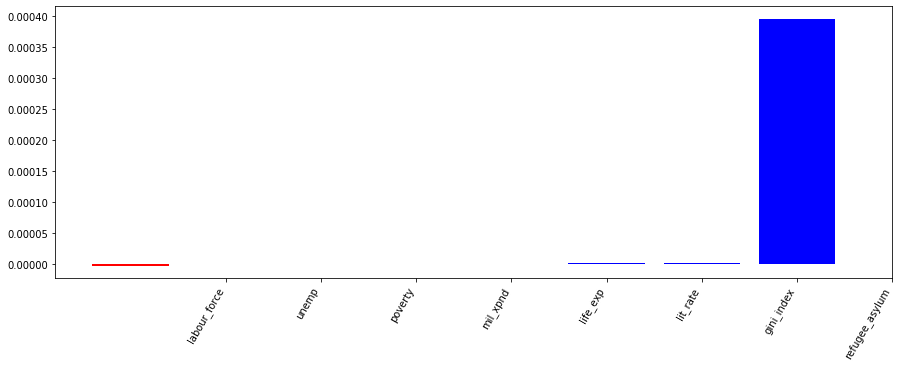

In [7]:
def plot_coefficients(model, feature_names, top_features=4):
 coef = model.coef_.ravel()
 top_positive_coefficients = np.argsort(coef)[-top_features:]
 top_negative_coefficients = np.argsort(coef)[:top_features]
 top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
 # create plot
 plt.figure(figsize=(15, 5))
 colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
 plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
 feature_names = np.array(feature_names)
 plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
#  plt.xlim(-1,1)
 plt.show()

plot_coefficients(linSVR, attributes)

In [53]:
weights = list(linSVR.coef_.ravel())
weights

[1.1969621591070794e-07,
 4.379676967886106e-07,
 -1.1750078918834596e-07,
 2.2171958712923874e-07,
 2.844375648216469e-09,
 6.50605582085156e-08,
 3.8049721222859444e-07,
 -1.0019992168281784e-06,
 0.00038853358330293264]

In [54]:
# linSVR.predict(X_test)
linSVR.score(X_test,y_test) # lmao this is so bad

-4.507110607725664

In [12]:
from sklearn.model_selection import GridSearchCV
def svr_param_selection(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10]
    # gammas = [0.001, 0.01, 0.1, 1]
    param_grid = {'C': Cs}
    grid_search = GridSearchCV(LinearSVR(), param_grid, cv=nfolds, scoring="neg_mean_absolute_error")
    grid_search.fit(X, y)
    # grid_search.best_params_
    return (grid_search.best_params_, grid_search.best_score_)

print(svr_param_selection(X_train,y_train,5))

({'C': 0.1}, -26.210578347783617)
